# 9 Modeling a Washing Machine Vibration

As an example we will study a model of washing machine vibrating. A washing machine typically has a structure that sits on the ground, usually on padded feet that provide some damping and then there is a drum that spins relative to the machine's main housing structure. Inside the drum, clothes can end up clumped in ways that cause the mass center of the contents of the drum to lie somewhere other than the spin axis. See this video for an example of what can happen:

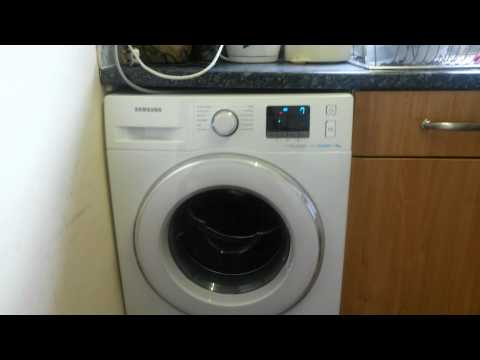

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('JqdAKPzdHDo')

## Process for using Lagrange's method for forming equations of planar

1. Decide on assumptions and simplifications that you should make about the real system. It's generally best to start with the simplest model possible and increase complexity if needed.
2. Draw a free body diagram to help visualize the system and all forces acting on it.
3. Pick generalized coordinates. These should be a minimal description to fully describe the configuration. (i.e. for a simple pendulum use the angle as the coordinate instead of the x and y position of the mass)
4. Write out the expressions for kinetic energy, potential energy, and dissipative energy.
5. Form the magnitudes of the velocities for each particle, magnitudes of velocities of each rigid body mass center, and the magnitude of the angular velocities of the rigid bodies.
6. Form the Lagrangian.
7. Form Lagrange's equation of the second kind.

For nonlinear analysis:

1. Introduce variables for generalized speeds and put nonlinear equations in first order form.

For linear analysis:

1. Determine the equilibrium point (set velocities and accelerations to zero and solve for generalized coordinates).
2. Linearize the nonlinear equations about the equilibrium point by either assuming small angles or calculating the first two terms of a Taylor series expansion.
3. Extract the mass, damping, and stiffness coefficients and the forcing vector.

## Lagrange's Equation of the Second Kind

$$\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{q}_i}\right) - \frac{\partial L}{\partial q_i} = Q_i \quad \textrm{ for } i = 1, \ldots, n$$

- $n$: number of generalized coordinates
- $q_i$: ith generalized coordinate
- $\dot{q}_i$: time derivative of the ith generalized coordinate
- $L$: Lagrangian, $L = T - U$
- $T$: Kinetic energy of the system (sum of the translational energies of each particle and translational/rotational energies of each rigid body)
- $U$: Potential energy of the system (sum of potentials due to gravity, springs, etc)
- $Q$: Non-conservative generalized forces
    - For viscous damping elements in a system $Q_i = -\frac{\partial R}{\partial \dot{q}_i}$, where $R = \frac{1}{2}\sum_{j=1}^n c_j v_j^2$
    
## Extra resources

- Free book chapters on modeling mechanical systems and Lagrange's equations: http://moodle.autolab.uni-pannon.hu/Mecha_tananyag/mechatronikai_modellezes_angol/ch11.html
- Wikipedia article on Lagrangian mechanics: https://en.wikipedia.org/wiki/Lagrangian_mechanics
- MIT Opencourseware lecture notes on Lagrangian mechanics: https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-07-dynamics-fall-2009/lecture-notes/MIT16_07F09_Lec20.pdf

# Imports and code setup

In [2]:
import sympy as sm

Here is a hack that will let $\frac{d y}{dt}$ appear as $\dot{y}$.

In [3]:
from sympy.printing.latex import LatexPrinter

class TimeDerivativePrinter(LatexPrinter):
    def _print_Derivative(self, expr):
        dim = len(expr.variables)
        t = sm.Symbol('t')
        if dim == 1 and expr.variables == (t,):
            return r"\dot{{{}}}".format(self._print(expr.args[0]))
        elif dim == 2 and expr.variables == (t, t): 
            return r"\ddot{{{}}}".format(self._print(expr.args[0]))
        else:
            return self._print(expr)
        
def latex(expr, **settings):
    return TimeDerivativePrinter(settings).doprint(expr)

In [4]:
sm.init_printing(latex_printer=latex)

# Modeling

I want to make the model (at least the first one) to be as simple as I can such that we can try to show the vibrations. Here are some assumptions:

- The washing can only move up and down relative to the ground.
- The "connection" of the washing machine to the ground may behave like a linear spring and damper.
- The washing machine can't leave the floor.
- The clothes can be represented by a point mass for now, just to cause the drum to be off balanced.

With those in mind, here is a basic free body diagram of the system:

![](fig/08/washing-machine-01.png)

# Define the constants

In [5]:
mw, mc, md, Icd, k, c, e, w, g, y0 = sm.symbols('m_w, m_c, m_d, I_cd, k, c, e, omega, g, y_0')

# Define the generalized coordinates

All generalized coordinates should be functions of time.

In [6]:
t = sm.symbols('t')

In [7]:
y = sm.Function('y')(t)

In [8]:
y

In [9]:
y.diff(t)

In [10]:
y.diff(t, 2)

# Form the total kinetic energy of the system

In [11]:
T = (mw * y.diff()**2 / 2 +  # vertical motion of washing machine
     md * y.diff()**2 / 2 +  # vertical motion of the drum
     Icd * w**2 / 2 +  # rotation of the drum
     mc * ((y.diff() + w * e * sm.cos(w * t))**2 + (w * e * sm.sin(w * t))**2) / 2)  # motion of the clothes mass center
T

# Form the total potential energy of the system

In [12]:
U = (mw * g * y +  # due to raising height of washing machine
     md * g * y +  # due to raising height of drum
     mc * g * (y + e * sm.sin(w * t)) +   # due to raising height of clothes
     k * (y - y0)**2 / 2)  # due to stretch away from free length of spring
U

# Form the total dissipative energy of the system

In [13]:
R = c * y.diff()**2 / 2  # due to dashpot
R

# Form the Lagrangian

In [14]:
L = T - U
L

## Form Lagrange's Equation of the Second Kind

There is only one generalized coordinate, $y$, so there will be one equation of motion for this single degree of freedom system.


$$f(y, \dot{y}, \ddot{y}) = \frac{d}{dt}\left(\frac{\partial L}{\partial \dot{y}}\right) - \frac{\partial L}{\partial y} + \frac{\partial R}{\partial\dot{y}} = 0$$

In [15]:
f = L.diff(y.diff()).diff(t) - L.diff(y) + R.diff(y.diff())
f

`.expand()` and `.collect()` can be used to show the equation in terms of each $y$ term.

In [16]:
f = f.expand().collect((y, y.diff(), y.diff(t, 2)))
f

Notice that the rotational centroidal inertia of the drum plays no role in the dynamics because it can't affect the vertical motion of the machine. We could have ignored that from the beginning if we made that realization and further simplified the model description. Note also that the left hand side of this equation is linear in $y,\dot{y},\ddot{y}$. Lastly, note the constant term $$-m_T g + k y_0$$. This term has to do with the free length and the total weight.

$$m_T \ddot{y} + c \dot{y} + k y = em_c\omega^2\sin(\omega t) - m_T g + k y_0$$

where

$$m_T = m_c + m_d + m_w$$

# Equilibrium

The above equations are valid, but with linear systems, we are typically interested in vibration about the equilibrium. The value of $y$ for equilibrium should be the value of the free length of the spring minus the distance compressed under the static load of the machine, i.e.:

$$y_{eq} = y_0 - \frac{m_T g}{k}$$

If you set the velocities and accelerations to zero in the equation of motion, this leaves the static force balance and solve it for the generalized coordinate will give the equilibrium value.

In [17]:
yeq = sm.solve(f.subs({y.diff(t, 2): 0, y.diff(t): 0, w: 0}), y)[0]  # note that solve returns a list, so [0] is needed
yeq

Now that we know the value of $y$ the system is at a equilibrium, we can write the equation of motion in terms it's motion with respect to the motion $\Delta y$ about the equilibrium, i.e. $y = y_{eq} + \Delta y$.

In [18]:
dely = sm.Function('\Delta y')(t)
dely

In [19]:
f_eq = f.subs({y.diff(t, 2): dely.diff(t, 2)}).subs({y.diff(t): dely.diff(t)}).subs({y: yeq + dely}).simplify()
f_eq

# Linear equations in canonical form

Notice how the gravity related force terms and the need for the spring's free length were eliminated.

The equation above also is linear wrt $\Delta y$, $\Delta\dot{y}$, and $\Delta\ddot{y}$. The $m$, $c$, and $k$ coefficients can be extracted:

In [20]:
m_coeff = f_eq.coeff(dely.diff(t, 2))
m_coeff

In [21]:
c_coeff = f_eq.coeff(dely.diff(t))
c_coeff

In [22]:
k_coeff = f_eq.coeff(dely)
k_coeff

The remaining term is the right hand side forcing term:

In [23]:
forcing = -(f_eq - m_coeff * dely.diff(t, 2) - c_coeff * dely.diff(t) - k_coeff * dely)
forcing

Now we have a linear single degree of freedom system with a sinusoidal forcing term that takes this form:

$$ m \Delta\ddot{y}(t) + c \Delta\dot{y}(t) + k \Delta y(t) = f_0 \sin(\omega t) $$

In [24]:
sm.Eq(m_coeff * dely.diff(t, 2) + c_coeff * dely.diff(t) + k_coeff * dely, forcing)

# The free length and equlibrium

Notice that the equation of motion of vibration about the equilibrium does not involve the free length or the weight of the machine. If you originally define your origin with respect to the static equilibrium you can write $U$ without the gravity potential energy terms related to the total weight because the energy stored in the compressed spring always equates to the energy gained from raising or lowering the mass. The free body diagram would look more like:

![](fig/08/washing-machine-02.png)

So the equation of motion can be formed more easily like:

In [25]:
U = (mc * g * e * sm.sin(w * t) +  # potential from height raise of mass of the clothes only
     k * y**2 / 2)  # potential due to stretch of spring away from equilibrium
U

In [26]:
L = T - U
f = L.diff(y.diff()).diff(t) - L.diff(y) + R.diff(y.diff())
sm.Eq(f.expand().collect(y.diff(t, 2)), 0)

Same equation of motion as above, but with fewer steps!